<img style="float: right; margin: 30px 15px 15px 15px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTFzQj91sOlkeDFkg5HDbjtR4QJYmLXkfMNig&usqp=CAU" width="300" height="400" /> 
    
    
### <font color='navy'> Modelos no Lineales para Pronósticos. </font>

**Nombres:**
> `Cárdenas Gallardo Paula Daniela` | `733720` <br> `Haces López José Manuel` | `734759` <br> `Villa Domínguez Paulo Adrián` | `733773`

**Fecha:** Mayo 2023
    
**Profesor:** Óscar David Jaramillo Zuluaga.
    
**Link Github**: [github.com](https://github.com/paucardenasg/Proyecto_MNLP)

# <font color='maroon'> Proyecto Final </font>

In [1]:
# Librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Carga de datos
data = pd.read_csv('./Data/dataset.csv')
# Eliminando la columna de index y Unit
data.drop(columns=['SN', 'Unit'], inplace=True)
# Poniendo el date a formato de fecha
data['Date'] = pd.to_datetime(data['Date'])
# Poniendo la fecha como str
data['Fecha_Str'] = data['Date'].dt.strftime('%Y-%m-%d')
# Cambiando el nombre de las columnas a español
data.rename(columns={'Date':'Fecha', 'Commodity':'Producto', 'Minimum':'Mínimo', 'Maximum':'Máximo', 'Average':'Promedio'}, inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Cargando el dataset del cambio de Rupia Nepali a Pesos
data_cambio = pd.read_excel('./Data/CambioMoneda.xlsx')
# Poniendo Fecha en formato de fech
data_cambio['Fecha'] = pd.to_datetime(data_cambio['Fecha'])
# Quitando la hora de la fecha
data_cambio['Fecha'] = data_cambio['Fecha'].dt.date
# Poniendo la fecha como str
data_cambio['Fecha_Str'] = data_cambio['Fecha'].astype(str)

# --------------------------------------------------------------------------------------------------------------------

# Obtener las clases de productos
productos_clase = data[['Producto']]
productos_clase = productos_clase.drop_duplicates()
# Tomar solo la primera palabra del valor de la columna de producto
productos_clase['Clase'] = productos_clase['Producto'].str.split(' ').str[0]
productos_clase['Clase'] = productos_clase['Clase'].str.split('(').str[0]

# Mergeando los datos con la clase de producto
data = data.merge(productos_clase, on='Producto')

# --------------------------------------------------------------------------------------------------------------------

# Juntando los dos datasets de tipo de cambio a pesos
data = data.merge(data_cambio.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Dataset con el precio del dolar
dolar = pd.read_excel('./Data/PrecioDolar.xlsx')
dolar['Fecha'] = pd.to_datetime(dolar['Fecha'])
# Quitando la hora de la fecha
dolar['Fecha'] = dolar['Fecha'].dt.date
# Poniendo la fecha como str
dolar['Fecha_Str'] = dolar['Fecha'].astype(str)

# Mergeando los datos con el precio del dolar
data = data.merge(dolar.drop(columns=['Fecha']), on='Fecha_Str')

# --------------------------------------------------------------------------------------------------------------------

# Multiplicando el precio por el cambio de moneda
data['Mínimo'] = np.round(data['Mínimo'] * data['Valor'], decimals=4)
data['Máximo'] = np.round(data['Máximo'] * data['Valor'], decimals=4)
data['Promedio'] = np.round(data['Promedio'] * data['Valor'], decimals=4)
# Eliminar la columna de valor
data.drop(columns=['Valor'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Sacando una columna con el año
data['Year'] = data['Fecha'].dt.year

# Dataset con la inflación
inflacion = pd.read_excel('./Data/Inflacion.xlsx')
data = data.merge(inflacion, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Agregando el porcentaje de desempleo
desempleo = pd.read_excel('./Data/Desempleo.xlsx')
data = data.merge(desempleo, on='Year')

# --------------------------------------------------------------------------------------------------------------------

# Poniendo la fecha como indice
data.set_index('Fecha', inplace=True)

# Ordenando los datos por fecha y por producto
data.sort_values(by=['Fecha', 'Producto'], inplace=True)

# --------------------------------------------------------------------------------------------------------------------

# Ordenando las columnas
data = data[['Producto', 'Clase', 'Mínimo', 'Máximo', 'Promedio', 'Inflacion', 'Precio_Dolar', 'Desempleo']]

data.head()

,Producto,Clase,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
Fecha,,,,,,,,
2013-06-16,Apple(Jholey),Apple,13.6746,16.4096,15.0421,9.04,90.456,10.5
2013-06-16,Asparagus,Asparagus,13.6746,20.5120,17.0933,9.04,90.456,10.5
2013-06-16,Bamboo Shoot,Bamboo,6.8373,8.2048,7.5211,9.04,90.456,10.5
2013-06-16,Banana,Banana,9.5723,10.9397,10.2560,9.04,90.456,10.5
2013-06-16,Bitter Gourd,Bitter,1.9145,2.1879,2.0512,9.04,90.456,10.5


## EDA

In [3]:
# Conocer las variables

# Tipo de cada variable
print(f'\n+ Tipo de datos por columna: \n{data.dtypes}')

# Conteo de valores nulos
print(f'\n+ Cantidad de nulos por columna: \n{data.isnull().sum()}')

# Valores únicos
print(f'\n+ Valores únicos por columna: \n{data.nunique()}')


+ Tipo de datos por columna: 
Producto         object
Clase            object
Mínimo          float64
Máximo          float64
Promedio        float64
Inflacion       float64
Precio_Dolar    float64
Desempleo       float64
dtype: object

+ Cantidad de nulos por columna: 
Producto        0
Clase           0
Mínimo          0
Máximo          0
Promedio        0
Inflacion       0
Precio_Dolar    0
Desempleo       0
dtype: int64

+ Valores únicos por columna: 
Producto          132
Clase              84
Mínimo          58427
Máximo          57747
Promedio        66988
Inflacion           9
Precio_Dolar     1779
Desempleo           6
dtype: int64


In [4]:
# Datos estadísticos de las variables
data.describe()

,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
count,169641.000000,169641.000000,169641.000000,169641.000000,169641.000000,169641.000000
mean,14.301900,15.737049,15.019474,6.151778,107.004676,11.083907
std,13.273342,14.085266,13.666749,1.982469,7.480348,0.972946
min,0.171300,0.807100,0.673600,3.630000,90.456000,10.400000
25%,6.069700,6.960500,6.504800,4.090000,100.920000,10.500000
50%,9.813700,11.037100,10.408900,5.570000,106.320000,10.600000
75%,16.890700,18.590400,17.743300,8.360000,113.370000,10.700000
max,316.025300,351.139200,333.582200,9.040000,122.138400,13.100000


In [5]:
# Mostrando fechas de inicio y fin de los datos, puras fechas sin hora
print('Fecha de inicio: ', data.index.min().date())
print('Fecha de fin: ', data.index.max().date())

Fecha de inicio:  2013-06-16
Fecha de fin:  2021-05-11


In [6]:
# Productos
tipos_de_productos = data['Producto'].unique()
print(f'Cantidad de Productos: {len(tipos_de_productos)}')

Cantidad de Productos: 132


In [7]:
# Porcentaje que representa cada producto
porcentaje = data['Producto'].value_counts(normalize=True).reset_index().sort_values(by='Producto', ascending=False)
# Multiplicando por 100 para obtener el porcentaje
porcentaje['Producto'] = np.round(porcentaje['Producto'] * 100, decimals=3)
# Haciendo una suma acumulativa
porcentaje['Cum_Sum'] = porcentaje['Producto'].cumsum()
porcentaje

,index,Producto,Cum_Sum
0,Ginger,1.385,1.385
1,Cauli Local,1.385,2.770
2,Cabbage(Local),1.384,4.154
3,Chilli Dry,1.384,5.538
4,Raddish White(Local),1.384,6.922
...,...,...,...
127,Maize,0.013,99.975
128,Mango(Calcutte),0.012,99.987
129,Sweet Lime,0.008,99.995
130,Musk Melon,0.004,99.999


___
## <font color='maroon'> Modelos Lineales </font>

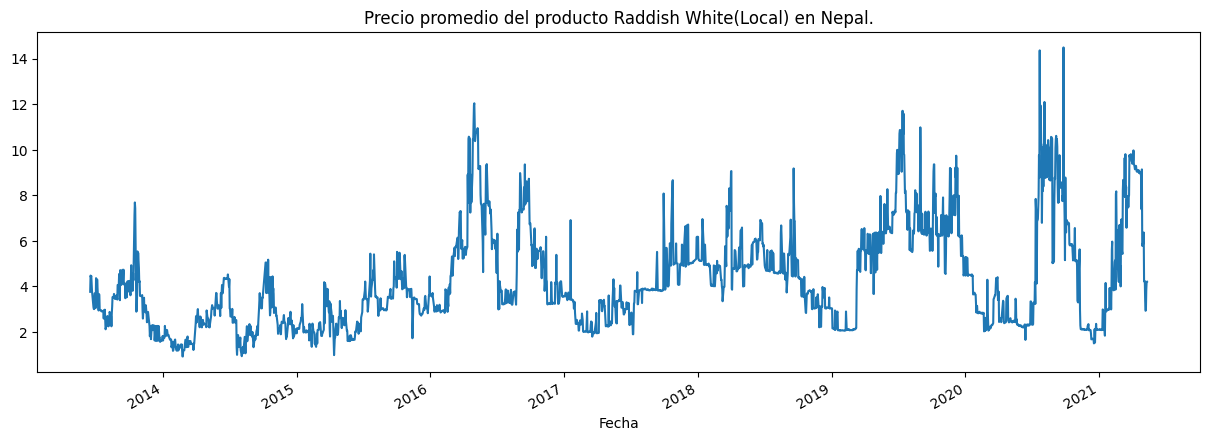

In [8]:
# Poniendo un seed para que siempre se obtenga el mismo resultado
np.random.seed(21)

# Random choice para seleccionar un producto al azar
producto = np.random.choice(tipos_de_productos)

# Graficando el promedio del producto seleccionado
data[data['Producto'] == producto]['Promedio'].plot(figsize=(15, 5), title=f'Precio promedio del producto {producto} en Nepal.')
plt.show()

In [9]:
data_prod = data.loc[data.Producto == producto]
data_prod

,Producto,Clase,Mínimo,Máximo,Promedio,Inflacion,Precio_Dolar,Desempleo
Fecha,,,,,,,,
2013-06-16,Raddish White(Local),Raddish,3.4187,4.1024,3.7605,9.04,90.4560,10.5
2013-06-17,Raddish White(Local),Raddish,4.1285,4.8166,4.4726,9.04,90.6610,10.5
2013-06-18,Raddish White(Local),Raddish,4.0639,4.7412,4.4025,9.04,92.6560,10.5
2013-06-19,Raddish White(Local),Raddish,4.1140,4.7997,4.4568,9.04,93.6930,10.5
2013-06-20,Raddish White(Local),Raddish,3.8433,4.3923,4.1178,9.04,94.4920,10.5
...,...,...,...,...,...,...,...,...
2021-05-07,Raddish White(Local),Raddish,2.5097,3.3463,2.9280,4.09,116.1029,12.2
2021-05-08,Raddish White(Local),Raddish,2.5282,3.3710,2.9496,4.09,115.2472,12.2
2021-05-09,Raddish White(Local),Raddish,3.4128,4.2660,3.8394,4.09,116.6448,12.2


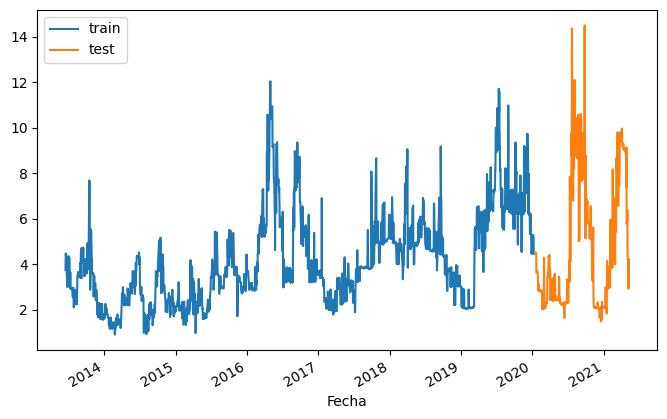

In [10]:
# Dividir en datos de entrenamiento (80%) y prueba (20%)
div = int(data_prod.shape[0]*.8)
train = data_prod[:div]
test = data_prod[div:]

# Visualizar partición entrenamiento - prueba
fig, ax = plt.subplots(figsize=(10, 5))
train['Promedio'].plot(figsize=(8,5), ax=ax,)
test['Promedio'].plot(figsize=(8,5), ax=ax)
ax.legend(labels = ['train', 'test'])
plt.show()

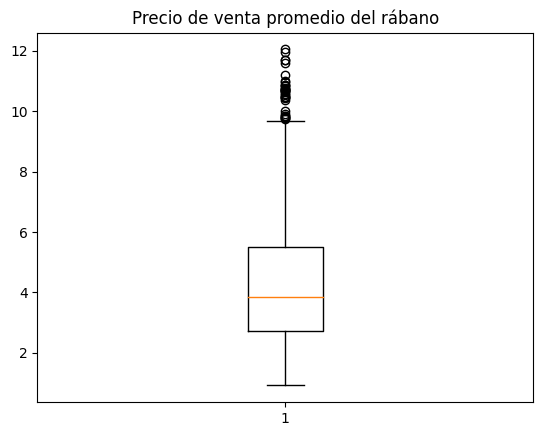

In [11]:
# Observar si hay datos atípicos
plt.boxplot(train['Promedio'])
plt.title('Precio de venta promedio del rábano')
plt.show()

## Pate Univariada con Deep Learning

In [12]:
from NN import NN_maker

In [13]:
# Para la parte univariada solo con la variable del promedio.
df = data_prod[["Promedio"]]
obj = NN_maker(data=df, n_steps= 7, horizont=14)

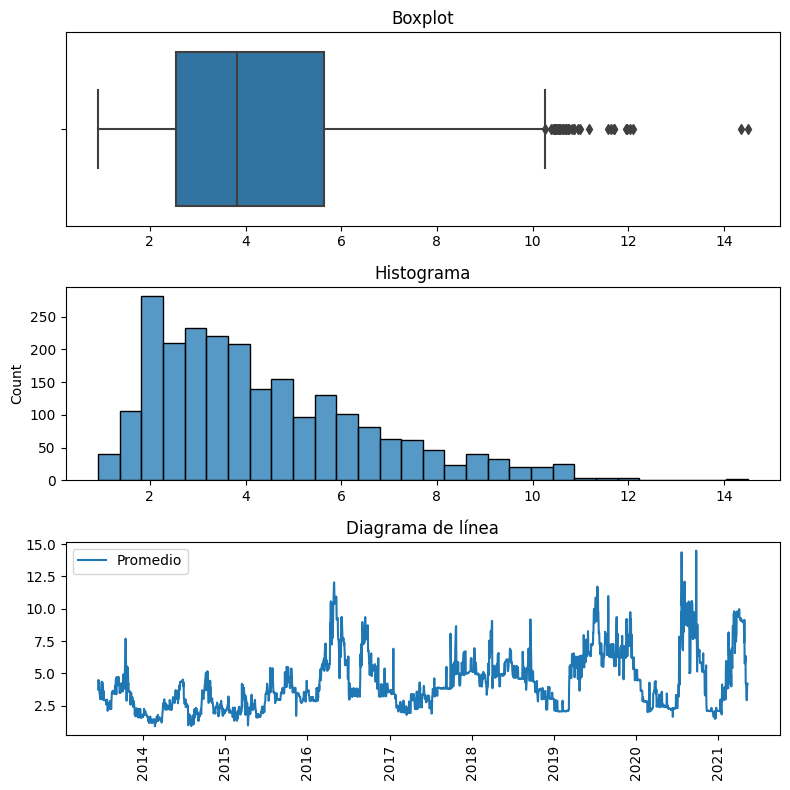

In [14]:
obj.plot_serie()

Al estar tan sesgada la serie, vamos a aplicar un logaritmo, a ver si mejora, ya que tiene una cola positiva, el logaritmo puede tender a mejorar la distribución de los datos.

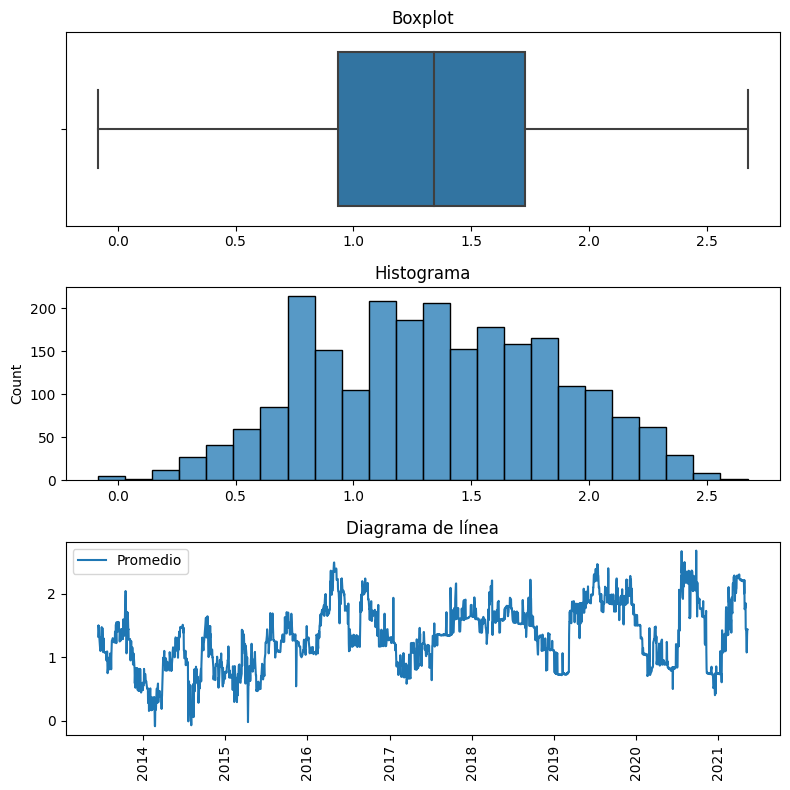

In [15]:
obj.transform_data()
obj.plot_serie()

En efecto ahora hay una distribución mucho más normal, vamos a proceder con el modelado de los datos, primero vamos a hacer un modelo muy simple mlp.

In [16]:
# Separamos los datos en train, val y test
X_train, X_val, X_test, y_train, y_val, y_test= obj.train_val_test_split()

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 7) (1870,)
Datos de validación (227, 7) (227,)
Datos de test (229, 7) (229,)


R2: 0.9253472266619723
MAE: 0.1019659043995045


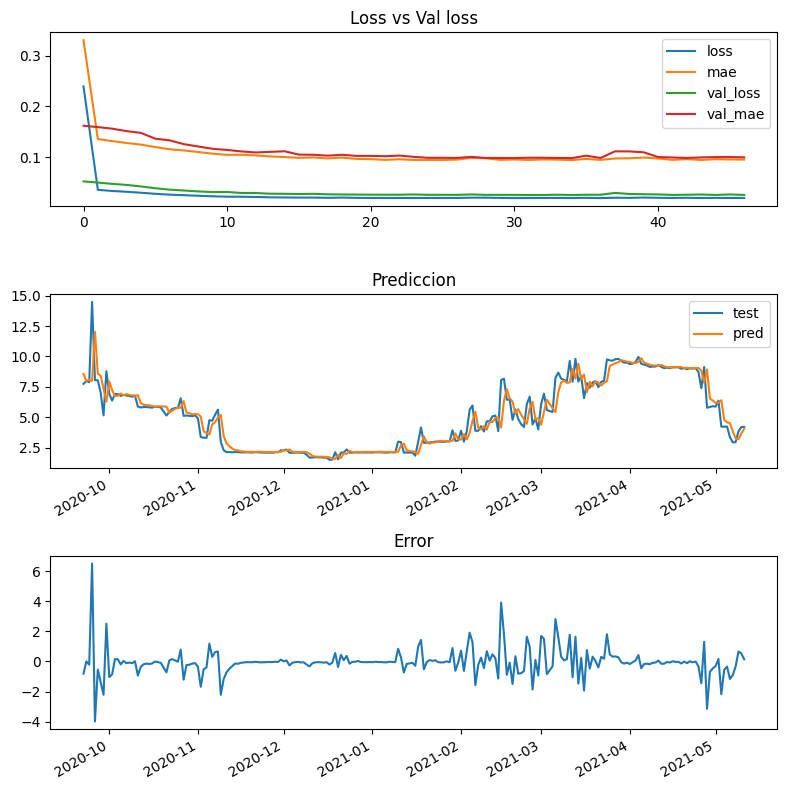

In [18]:
# Ejecutamos un modelo sencillo con solo 1 capa oculta y 32 neuronas
num_hidden_layers = 1
num_neurons = 32
dropout_rate = None

model_mlp_1 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True)

R2: 0.796553242671873
MAE: 0.21533804795085337


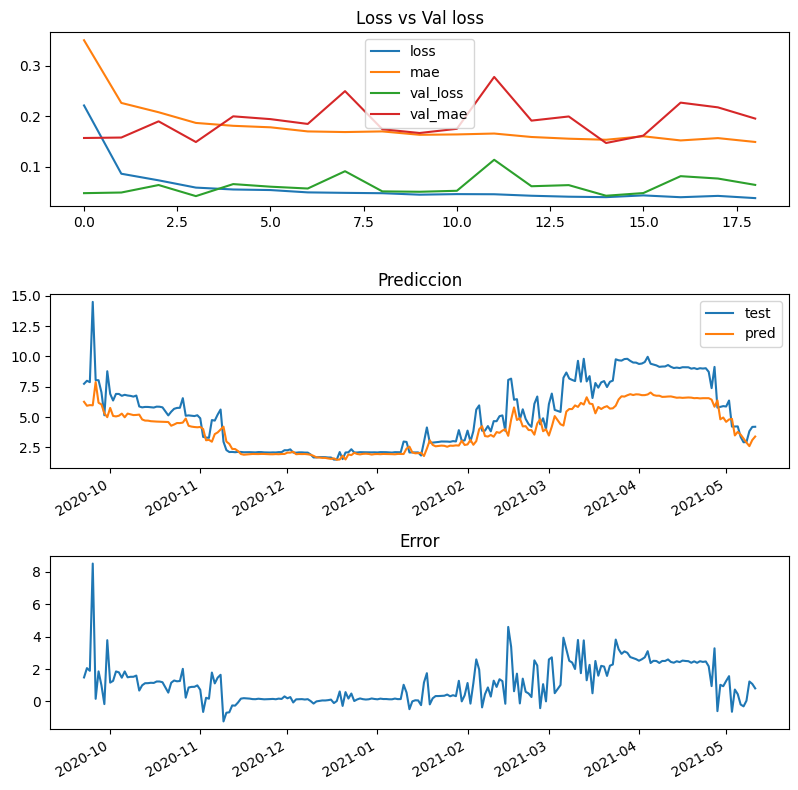

In [21]:
# Ahora corremos con 2 capas ocultas y 64 neuronas, agregamos dropout para evitar overfitting
num_hidden_layers = 2
num_neurons = 64
dropout_rate = 0.2

model_mlp_2 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True, dropout_rate=dropout_rate)

Parece que las capas ocultas evitaron que siga aprendiendo, voy a intentar, dejando el dropout y quitando una oculta.

R2: 0.910061927254655
MAE: 0.13370028002557452


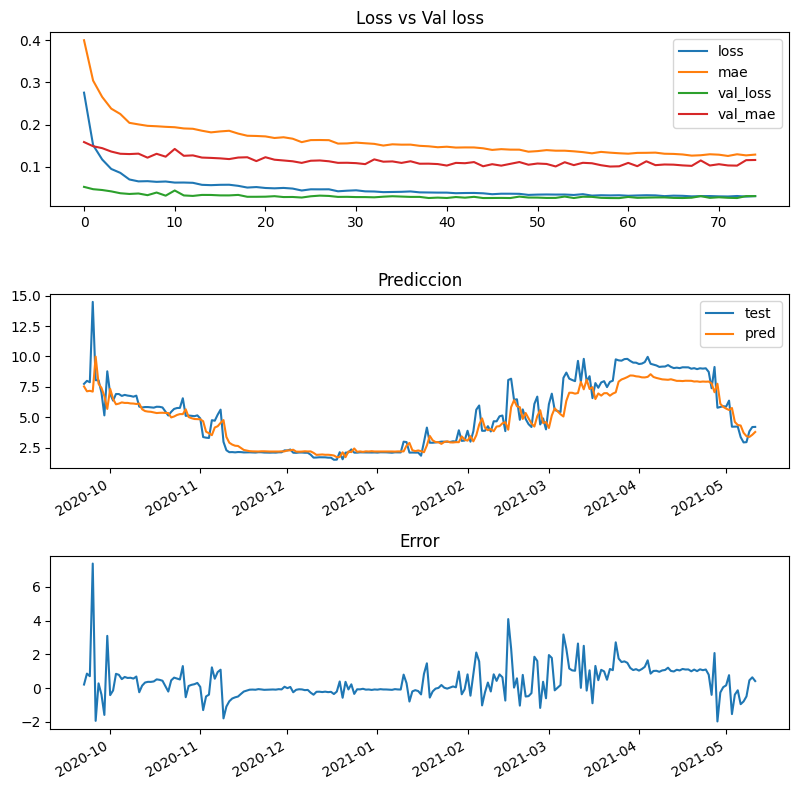

In [22]:
# Vamos a quitar una capa oculta y jugar con el dropout.
num_hidden_layers = 1
num_neurons = 64
dropout_rate = 0.2

model_mlp_3 = obj.MLP_builder(num_hidden_layers=num_hidden_layers, X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                        y_val=y_val, y_test=y_test, num_neurons=num_neurons, log=True, plot=True, dropout_rate=dropout_rate)

## CNN

In [23]:
# Separamos en train, val y test. y reordenamos en forma tensorial con el parametro conv.
X_train, X_val, X_test, y_train, y_val, y_test = obj.train_val_test_split(conv=True)

# Imprimir dimensiones de los datos de entrenamiento, validación y test
print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 7, 1) (1870, 1)
Datos de validación (227, 7, 1) (227, 1)
Datos de test (229, 7, 1) (229, 1)


R2: 0.921962784835108
MAE: 0.10596529953442069


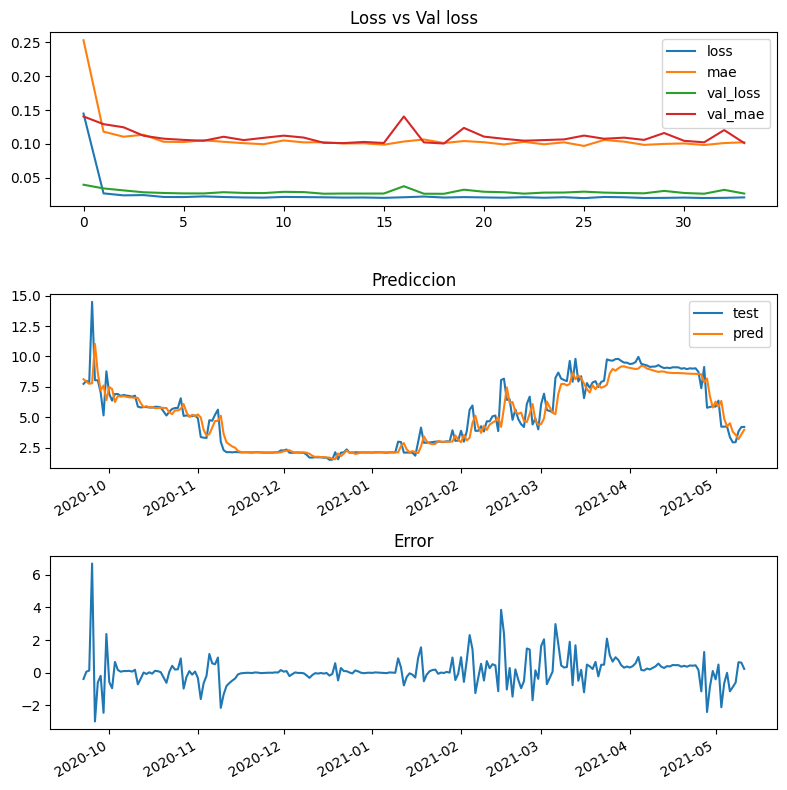

In [24]:
# Ejecutamos nuestra primer red, solo una capa oculta
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2

model_cnn_1 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, plot=True, log=True)

R2: 0.9205776388643304
MAE: 0.10722279772086331


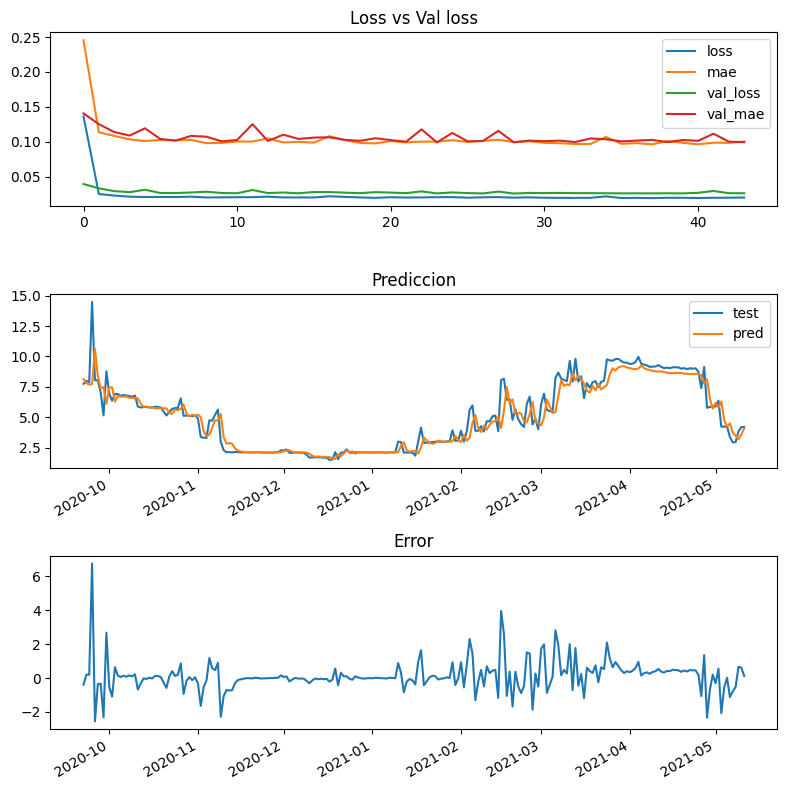

In [26]:
# Dió muy buen resultado, pero los picos todavía no me convencen
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2

model_cnn_2 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, plot=True, log=True)

R2: 0.9220644808430766
MAE: 0.10606743831657234


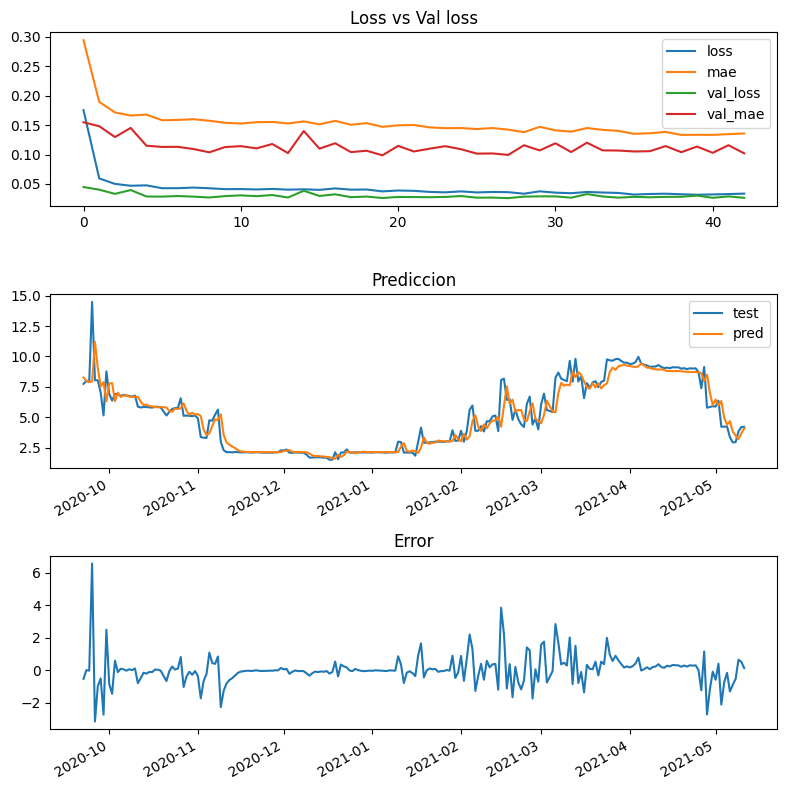

In [28]:
# veamos si el dropout hace algun buen efecto en la red
num_hidden_layers = 1
num_neurons = 256
num_filters = 64
kernel_size = 2
dropout_rate = 0.5

model_cnn_3 = obj.cnn_builder(num_hidden_layers=num_hidden_layers, num_neurons=num_neurons,
                                    num_filters=num_filters, kernel_size=kernel_size, pool_size=2,
                                    X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train,
                                    y_val=y_val, y_test=y_test, dropout_rate=dropout_rate, plot=True, log=True)

## LSTM

R2: -0.5941220147106221
MAE: 0.5813601425467372


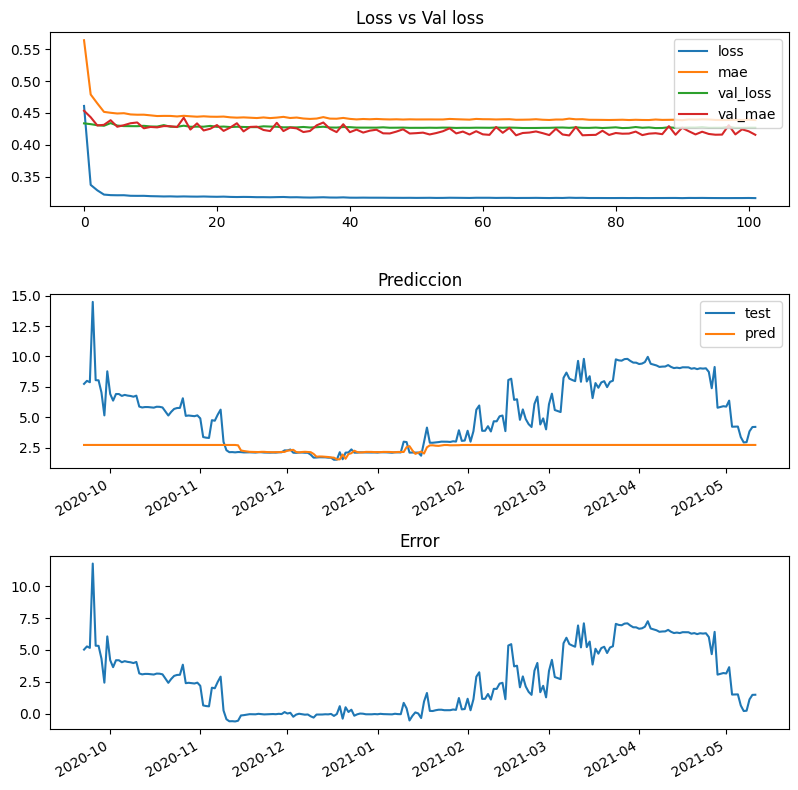

In [29]:
units_lstm = 50
capas_ocultas_dense = 1
units_dense = 32

model_lstm_1 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, 
                                     y_val=y_val, y_test=y_test, plot=True, dropout=None, log=True)

Modelo muy malo, vamos a ver si con otros parámetros puede mejorar.

R2: -0.592990467940627
MAE: 0.5803133654003897


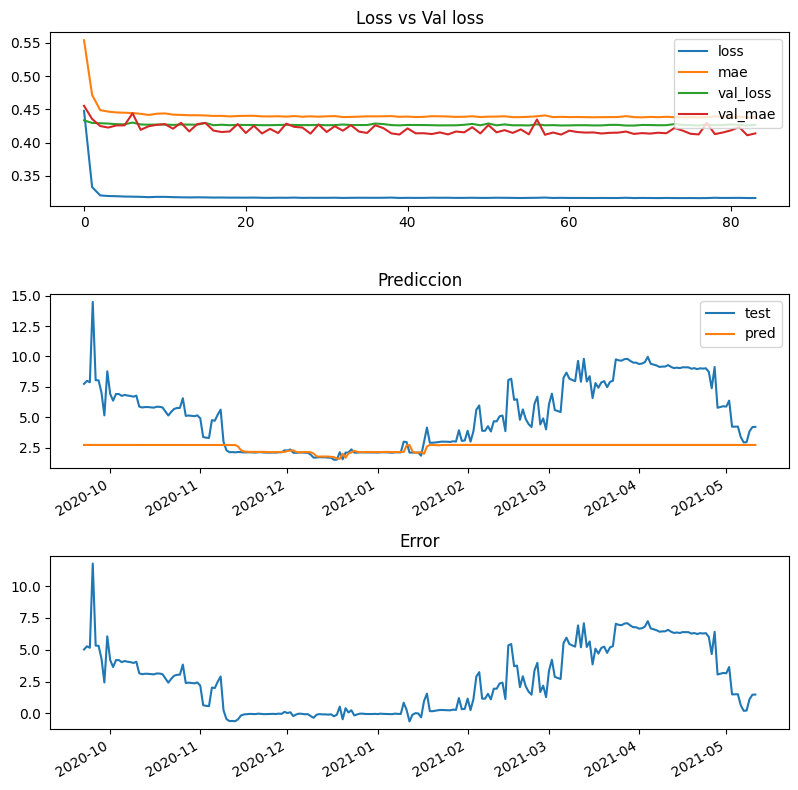

In [30]:
# Pesimo modelo, vamos agregando más parámetros
units_lstm = 50
capas_ocultas_dense = 3
units_dense = 128

model_lstm_2 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, 
                                     y_test=y_test, plot=True, dropout=None, log=True)

R2: -0.6596539628990341
MAE: 0.6423198467338158


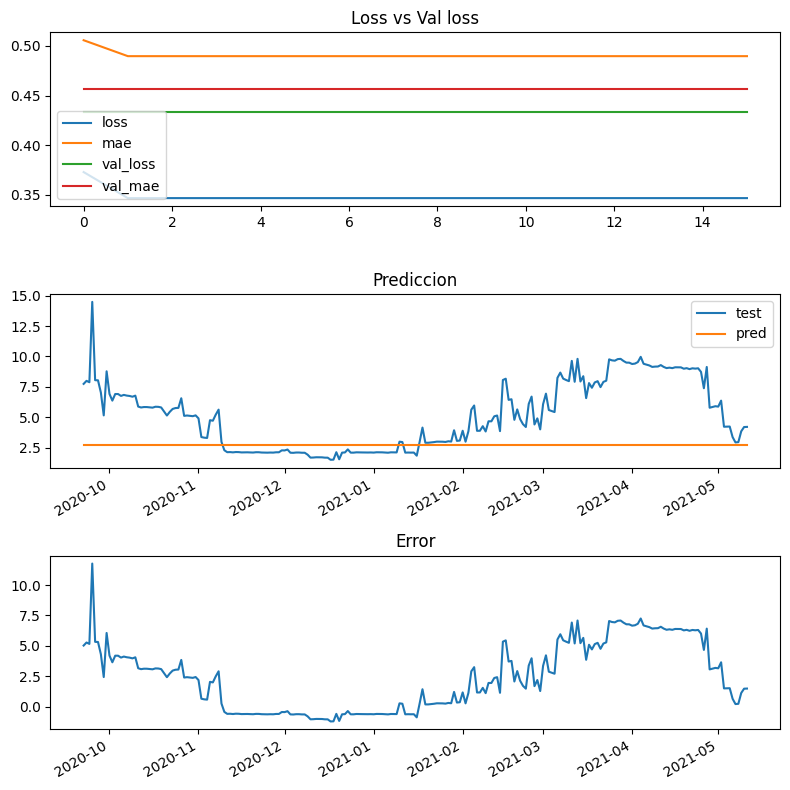

In [31]:
# Vamos a ver si con más unidades lstm se puede mejorar el modelo
units_lstm = 500
capas_ocultas_dense = 5
units_dense = 526

model_lstm_3 = obj.lstm_builder(units_lstm=units_lstm, capas_ocultas_lstm=1, capas_ocultas_dense=capas_ocultas_dense, 
                                     units_dense=units_dense, X_train = X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, 
                                     y_test=y_test, plot=True, dropout=None, log=True)

## CNN-LSTM

In [16]:
# Separamos en train, val y test. y reordenamos en forma tensorial con el parametro conv.
X_train, X_val, X_test, y_train, y_val, y_test = obj.train_val_test_split(conv=True)

n_features = 1
n_seq = 1
n_steps = 7
X_train = X_train.reshape((X_train.shape[0], n_seq, n_steps, n_features))
X_val = X_val.reshape((X_val.shape[0], n_seq, n_steps, n_features))
X_test = X_test.reshape((X_test.shape[0], n_seq, n_steps, n_features))

print('Datos de entrenamiento', X_train.shape, y_train.shape)
print('Datos de validación', X_val.shape, y_val.shape)
print('Datos de test', X_test.shape, y_test.shape)

Datos de entrenamiento (1870, 1, 7, 1) (1870, 1)
Datos de validación (227, 1, 7, 1) (227, 1)
Datos de test (229, 1, 7, 1) (229, 1)


R2: 0.8785068153126773
MAE: 0.14609314122112668


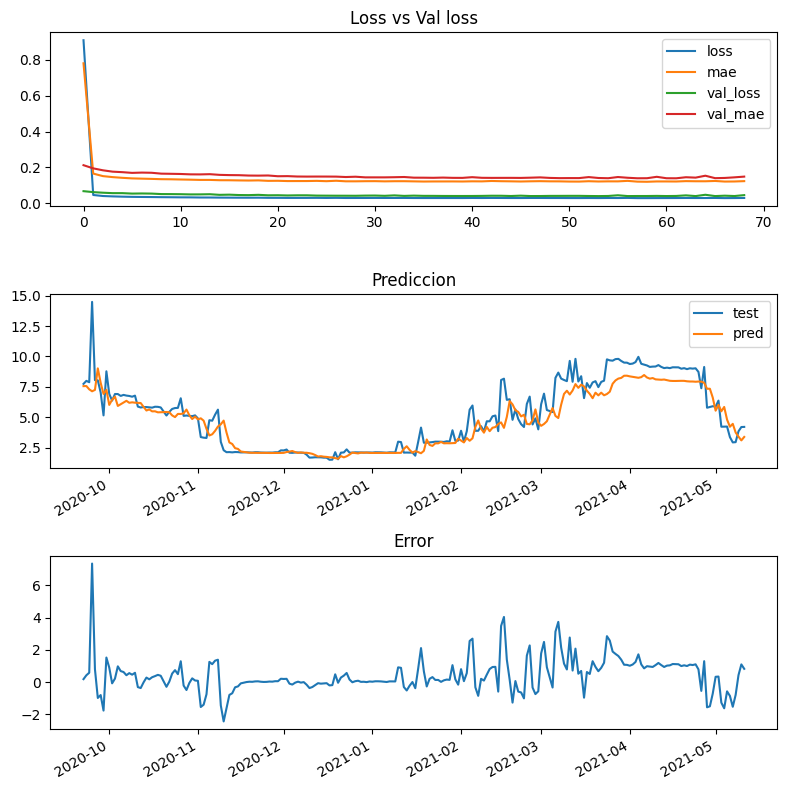

In [17]:
# Empezamos 
blocks = 1
filters = 10
units_lstm = 30

model_cnn_lstm_1 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=None, log=True)

R2: 0.8880052742958127
MAE: 0.1300085731390494


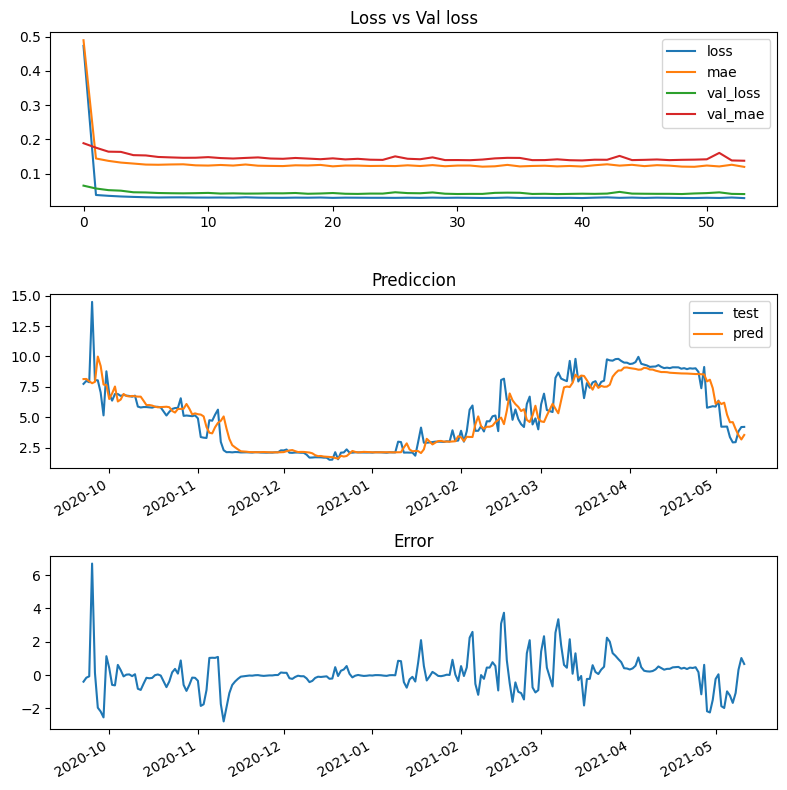

In [19]:
blocks = 1
filters = 40
units_lstm = 50

model_cnn_lstm_2 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=None, log=True)

R2: 0.8835982630646074
MAE: 0.13590225830505073


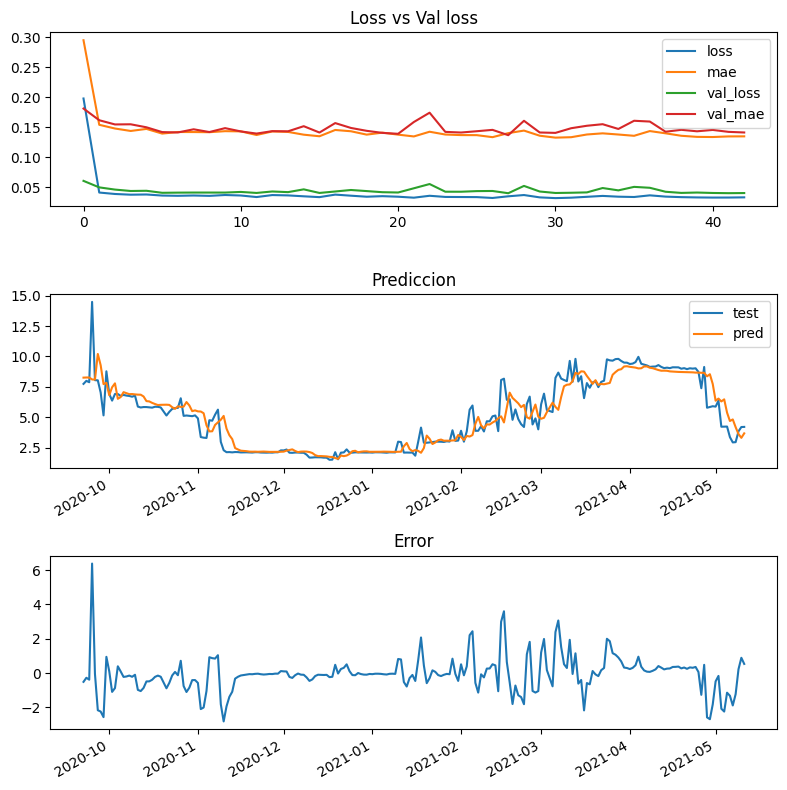

In [20]:
blocks = 1
filters = 256
dropout_rate = 0.2
units_lstm = 100

model_cnn_lstm_3 = obj.cnn_lstm_builder(blocks=blocks, filters=filters, units_lstm=units_lstm,  X_train=X_train, X_val=X_val, 
                                             X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test, plot=True, 
                                             dropout=dropout_rate, log=True)

El mejor modelo conseguido fue una CNN, vamos a hacer un optuna con esa arquitectura.

In [25]:
from tensorflow.keras.layers import Dense, MaxPooling1D, Dropout, Conv1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow import keras
import optuna

# Separamos los datos en train, val y test
X_train, X_val, X_test, y_train, y_val, y_test= obj.train_val_test_split(conv=True)


def objective(trial):
    # Definir los hiperparámetros que queremos optimizar
    filters = trial.suggest_int("filters", 32, 128)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    dense_size = trial.suggest_int("dense_size", 64, 256)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)

    # Construir el modelo con los hiperparámetros elegidos
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dense(1))

    # Compilar el modelo con el optimizador y la función de pérdida
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    # Entrenar el modelo y obtener las predicciones
    history = model.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=256,
            epochs=200,
            verbose=False)
    val_loss = history.history['val_loss'][-1]
    return val_loss

In [28]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Imprimir los resultados
print('Best trial:', study.best_trial.params)
print('Best validation loss:', study.best_trial.value)

[I 2023-05-08 14:37:37,861] A new study created in memory with name: no-name-de6be1f4-c45a-4bfc-abba-4952d81862f6
[I 2023-05-08 14:38:09,879] Trial 0 finished with value: 0.18222744762897491 and parameters: {'filters': 123, 'dropout': 0.34774377053456396, 'dense_size': 231, 'learning_rate': 0.0010004186964755065}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:38:38,130] Trial 1 finished with value: 0.23608481884002686 and parameters: {'filters': 117, 'dropout': 0.43792050098226565, 'dense_size': 166, 'learning_rate': 0.0005815326989089515}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:39:04,187] Trial 2 finished with value: 0.2778153419494629 and parameters: {'filters': 72, 'dropout': 0.4689176715595162, 'dense_size': 246, 'learning_rate': 5.807026684886073e-05}. Best is trial 0 with value: 0.18222744762897491.
[I 2023-05-08 14:39:30,131] Trial 3 finished with value: 0.19095176458358765 and parameters: {'filters': 78, 'dropout': 0.44021927823125

Best trial: {'filters': 97, 'dropout': 0.20694595818553246, 'dense_size': 189, 'learning_rate': 0.0068903542803917615}
Best validation loss: 0.05588889867067337


In [30]:
# Imprimimos los mejores parámetros
dict_params = study.best_params
dict_params

{'filters': 97,
 'dropout': 0.20694595818553246,
 'dense_size': 189,
 'learning_rate': 0.0068903542803917615}

R2: 0.9204915033526033
MAE: 0.10912021591982411


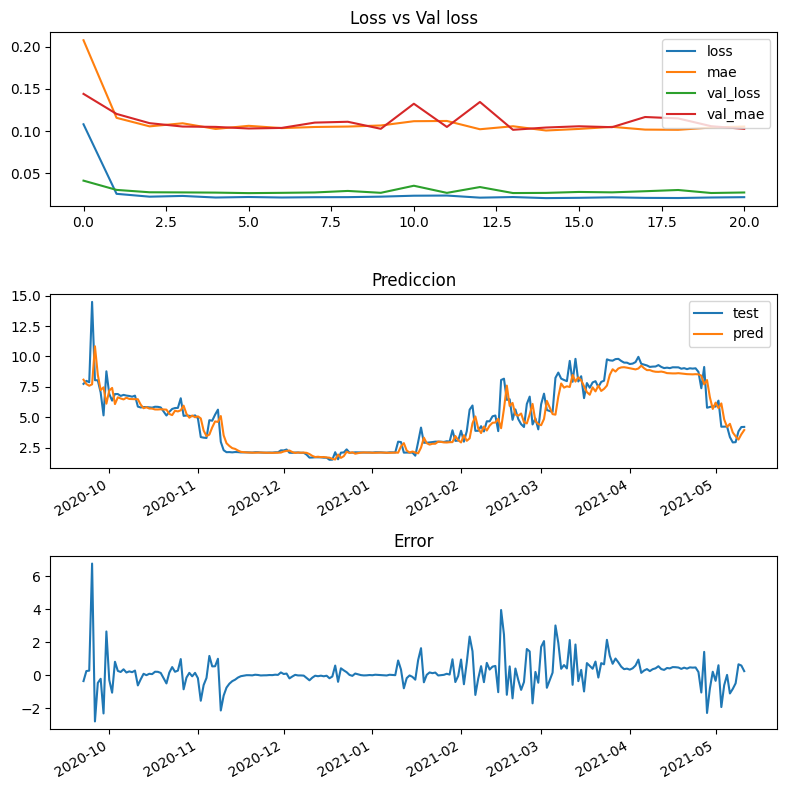

In [40]:
# Ejecutamos nuestra red con datos optimizados
dense_size = dict_params["dense_size"]
dropout = dict_params["dropout"]
filters = dict_params["filters"]
lr = dict_params["learning_rate"]

# Construir el modelo con los hiperparámetros elegidos
model = Sequential()
model.add(Conv1D(filters=filters, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(dense_size, activation='relu'))
model.add(Dense(1))

# Compilar el modelo con el optimizador y la función de pérdida
optimizer = keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer, loss='mse')

obj.train_models(model=model, X_train=X_train, X_val=X_val, X_test=X_test, 
                 y_train=y_train, y_val=y_val, y_test=y_test, log=True, plot=True)

Pues salió bastante parecido el resultado del modelo solo que con menos neuronas, filtros, etc. Entonces se puede considerar que nos funcionó el optuna.